# Sample Clarius Analysis

# Select Image & Phantom and Parse

In [28]:
from pyquantus.parse.clarius import clariusRfParser

rf_path = '/Volumes/CREST Data/David_S_Data/Clarius_RF_Data/f2540449-af21-4e92-aef6-45ecfd28dd6f/2024-11-01T11-36-16+0000_rf.raw'
rf_tgc_path = '/Volumes/CREST Data/David_S_Data/Clarius_RF_Data/f2540449-af21-4e92-aef6-45ecfd28dd6f/2024-11-01T11-36-16+0000_env.tgc.yml'
info_path = '/Volumes/CREST Data/David_S_Data/Clarius_RF_Data/f2540449-af21-4e92-aef6-45ecfd28dd6f/2024-11-01T11-36-16+0000_rf.yml'

imgData, imgInfo, refData, refInfo = clariusRfParser(rf_path, rf_tgc_path, info_path,
                                                    rf_path, rf_tgc_path, info_path)

The number of missing timestamps for /Volumes/CREST Data/David_S_Data/Clarius_RF_Data/f2540449-af21-4e92-aef6-45ecfd28dd6f/2024-11-01T11-36-16+0000_env.tgc.yml is: 30. Skipping this scan with current criteria.
A default TGC matrix of size (192, 2928, 30) is generated.
A default TGC matrix of size (192, 2928, 30) is generated.
The number of missing timestamps for /Volumes/CREST Data/David_S_Data/Clarius_RF_Data/f2540449-af21-4e92-aef6-45ecfd28dd6f/2024-11-01T11-36-16+0000_env.tgc.yml is: 30. Skipping this scan with current criteria.
A default TGC matrix of size (192, 2928, 30) is generated.
A default TGC matrix of size (192, 2928, 30) is generated.


# ROI Selection (from GUI)

In [29]:
import pickle

pkl_name = "/Volumes/CREST Data/David_S_Data/Clarius_RF_Data/f2540449-af21-4e92-aef6-45ecfd28dd6f/roi.pkl"

with open(pkl_name, 'rb') as f:
    roi_info = pickle.load(f)

/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_83668/3772181726.py:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  roi_info = pickle.load(f)


In [30]:
from pathlib import Path

assert roi_info['Image Name'] == Path(rf_path).name
assert roi_info['Phantom Name'] == Path(rf_path).name

In [31]:
scSplineX = roi_info["Spline X"]
scSplineY = roi_info["Spline Y"]
frame = roi_info["Frame"]

# Analysis Config (from GUI)

In [32]:
from pyquantus.qus import AnalysisConfig

import pickle
pkl_name = "/Volumes/CREST Data/David_S_Data/Clarius_RF_Data/f2540449-af21-4e92-aef6-45ecfd28dd6f/analysis-config.pkl"

with open(pkl_name, "rb") as f:
    config_info = pickle.load(f)

In [33]:
config = config_info["Config"]

# Spectral Analysis

In [34]:
from pyquantus.qus import UltrasoundImage

ultrasoundImage = UltrasoundImage()
ultrasoundImage.axialResRf = imgInfo.depth / imgData.rf[frame].shape[0]
ultrasoundImage.lateralResRf = ultrasoundImage.axialResRf * (
    imgData.rf[frame].shape[0]/imgData.rf[frame].shape[1]
) # placeholder
ultrasoundImage.bmode = imgData.bMode[frame]
ultrasoundImage.scBmode = imgData.scBmode[frame]
ultrasoundImage.phantomRf = refData.rf[0]
ultrasoundImage.rf = imgData.rf[frame]
ultrasoundImage.xmap = imgData.scBmodeStruct.xmap
ultrasoundImage.ymap = imgData.scBmodeStruct.ymap

In [35]:
from pyquantus.qus import SpectralAnalysis

spectralAnalysis = SpectralAnalysis()
spectralAnalysis.ultrasoundImage = ultrasoundImage
spectralAnalysis.config = config
spectralAnalysis.initAnalysisConfig()
spectralAnalysis.scSplineX = scSplineX
spectralAnalysis.scSplineY = scSplineY

In [36]:
spectralAnalysis.splineToPreSc()
spectralAnalysis.generateRoiWindows()
spectralAnalysis.computeSpecWindows()

/Users/davidspector/Home/Stanford/QuantUS Projects/QuantUS/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/davidspector/Home/Stanford/QuantUS Projects/QuantUS/.venv/lib/python3.11/site-packages/pyquantus/qus/analysis.py:193: RuntimeWarning: divide by zero encountered in divide
  u = (w**2) / np.var((r / p) ** 2, axis=1)


# Visualizations

In [37]:
from pyquantus.qus import SpectralData
from pyquantus.parse.objects import ScConfig

scConfig = ScConfig()
scConfig.width = imgInfo.width1
scConfig.tilt = imgInfo.tilt1
scConfig.startDepth = imgInfo.startDepth1
scConfig.endDepth = imgInfo.endDepth1

spectralData = SpectralData()
spectralData.spectralAnalysis = spectralAnalysis
spectralData.scConfig = scConfig

In [38]:
spectralData.convertImagesToRGB()

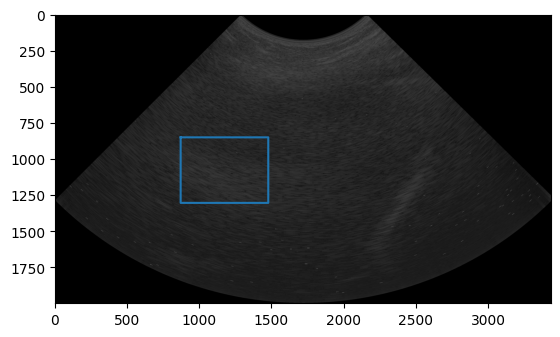

In [39]:
import matplotlib.pyplot as plt
import numpy as np

newArr = np.clip(ultrasoundImage.scBmode, 0, 255)

plt.imshow(spectralData.scBmode)
plt.plot(scSplineX, scSplineY)

In [40]:
spectralData.drawCmaps()
spectralData.scanConvertCmaps()

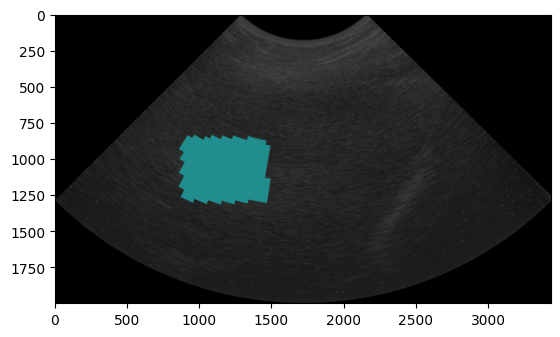

In [41]:
# Note cmap is solid as image = phantom in this case
plt.imshow(spectralData.scMbfIm) 